### Introduction: This is the Jupyter notebook to do the flowing things:

1. Plot polynomial shapes from Combine output.

env:HWW


### Import necessary modules

In [2]:
import numpy as np
import os
import pandas as pd
import random
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from scipy import interpolate
# from sklearn.metrics import roc_curve, auc
from cycler import cycler
import uproot
# means uproot4
import ROOT
import argparse
import glob
import json
import logging
import os
import pickle as pkl
import warnings

import hist as hist2
import pyarrow
# import utils #local file: utils.py
import yaml
from typing import Dict, List, Union
from dataclasses import dataclass
from copy import deepcopy

# from coffea import hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import vector
# from coffea.nanoevents.methods.vector import PtEtaPhiMLorentzVector

/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:559:40: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/uses_allo

Welcome to JupyROOT 6.28/04


In [32]:
MAIN_DIR = "../.."

plot_dir = f"{MAIN_DIR}/plots/tf/01Feb24"
_ = os.system(f"mkdir -p {plot_dir}")

### Define a function to read the root files

In [33]:
def read_root(filename = "/home/pku/zhaoyz/Higgs/MDStudy/SR1a_Shape.root", dir = "QCD", name = "SRa"):
    ''' 
    filename:path/to/root
    dir:"QCD"
    name:region from ["CR1",...]
    '''
    with uproot.open(filename) as file:
        hist = file.get(dir + "/" + name)
        h = np.array(hist.values())
        var = np.array(hist.variances())        
    return h, var
    # here we defined a simple function to read the predicted QCD,etc. shapes from root file directly
    # but you have to be sure with the accuracy about the root file

import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])

### Read the root files and plot the histogram ratio.

/tmp/ipykernel_1584653/2771136032.py:34: RuntimeWarning: divide by zero encountered in divide
  number = h**2 / var
/tmp/ipykernel_1584653/2771136032.py:51: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_1584653/2771136032.py:52: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h
/tmp/ipykernel_1584653/2771136032.py:34: RuntimeWarning: divide by zero encountered in divide
  number = h**2 / var
/tmp/ipykernel_1584653/2771136032.py:51: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_1584653/2771136032.py:52: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h


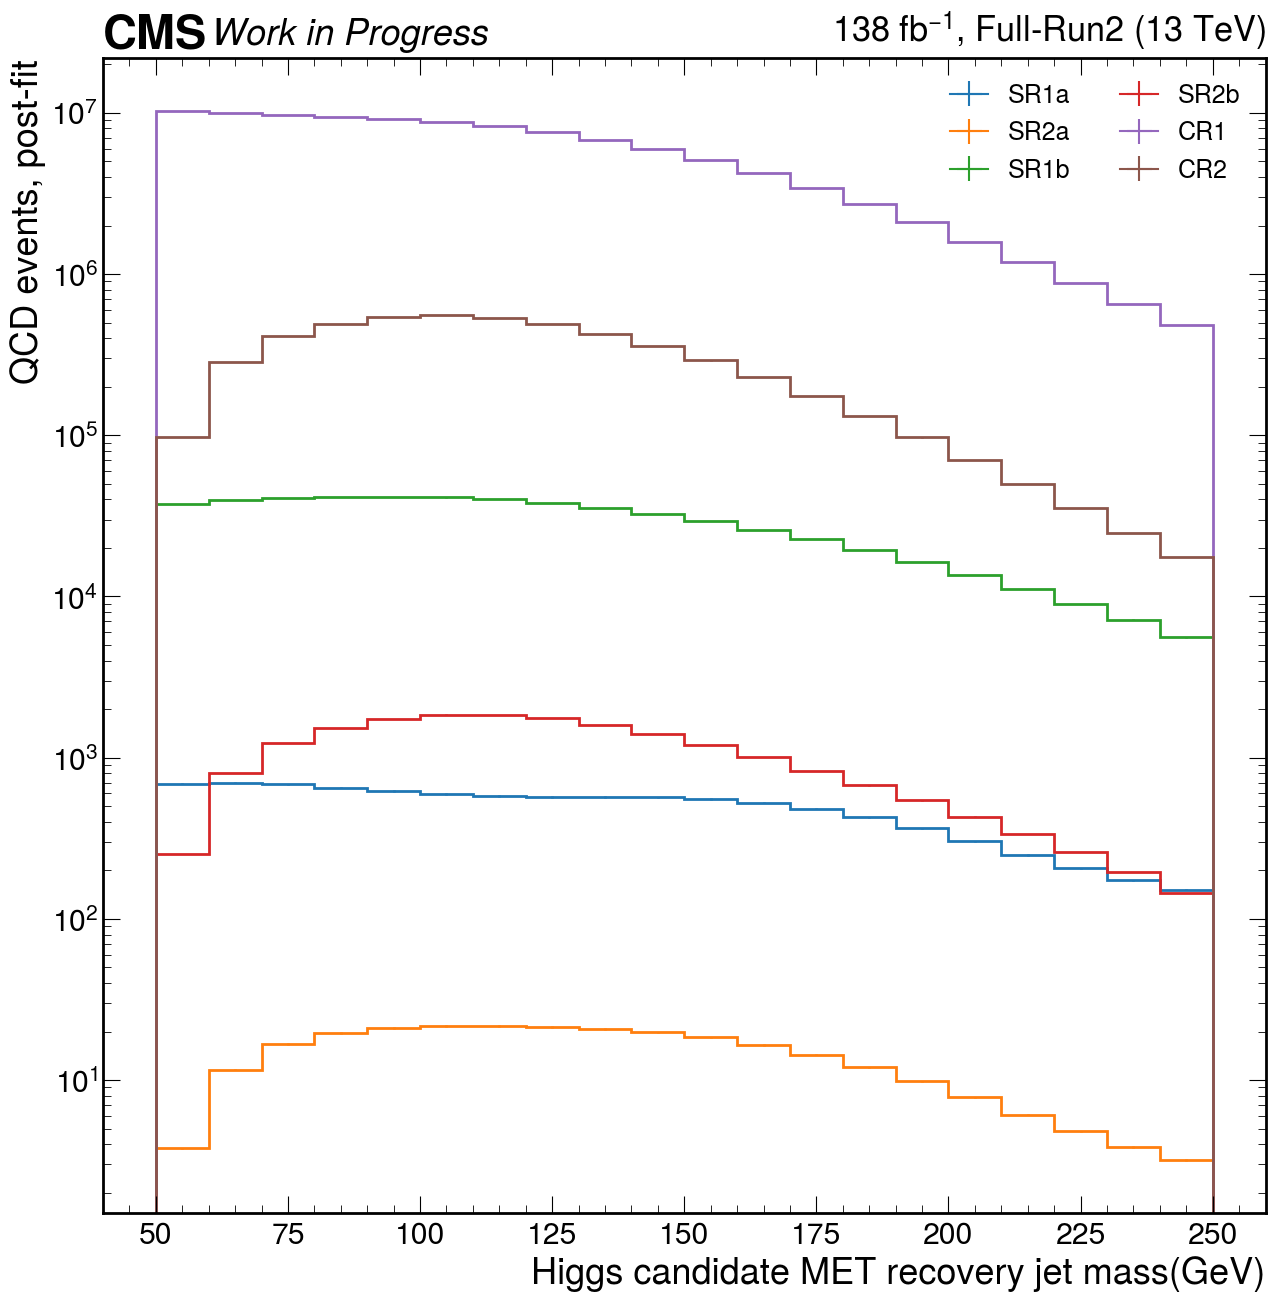

In [34]:
postfit_files = "/home/pku/zhaoyz/Higgs/boostedHWW/combine/f_test/cards/nTF_6/FitShapes.root"
regions = ["SR1a","SR2a","SR1b","SR2b","CR1","CR2"]

histograms = {'h':{},'var':{}}
hep.style.use("CMS")
plt.figure(figsize=(15, 15))
ax = plt.gca()
hep.cms.label(
        "Work in Progress",
        ax=ax,
        data=True,
        lumi=138,
        year="Full-Run2",
    )
for region in regions:
    hist = bh.Histogram(bh.axis.Regular(20, 50, 250), storage=bh.storage.Weight())
    histograms['h'][region], histograms['var'][region] = read_root(filename = postfit_files, dir = region + "_postfit", name = "CMS_HWW_boosted_qcd_datadriven")
    hep.histplot(histograms['h'][region], bins=hist.axes[0].edges, yerr=np.nan_to_num(error_bar(histograms['h'][region], histograms['var'][region], type = "mc"), nan = 0), label=region, histtype='step', stack=False, linewidth=2, ax=ax)
    ax.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
    ax.set_ylabel("QCD events, post-fit")
    ax.set_yscale('log') 
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=18)
plt.savefig(f"{plot_dir}/QCD_postfit.pdf", bbox_inches='tight')

### Plot the ratio of signal region/ control region, this should be the tf

/tmp/ipykernel_1584653/2771136032.py:34: RuntimeWarning: divide by zero encountered in divide
  number = h**2 / var
/tmp/ipykernel_1584653/2771136032.py:51: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_1584653/2771136032.py:52: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h
/tmp/ipykernel_1584653/2771136032.py:34: RuntimeWarning: divide by zero encountered in divide
  number = h**2 / var
/tmp/ipykernel_1584653/2771136032.py:51: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_1584653/2771136032.py:52: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h


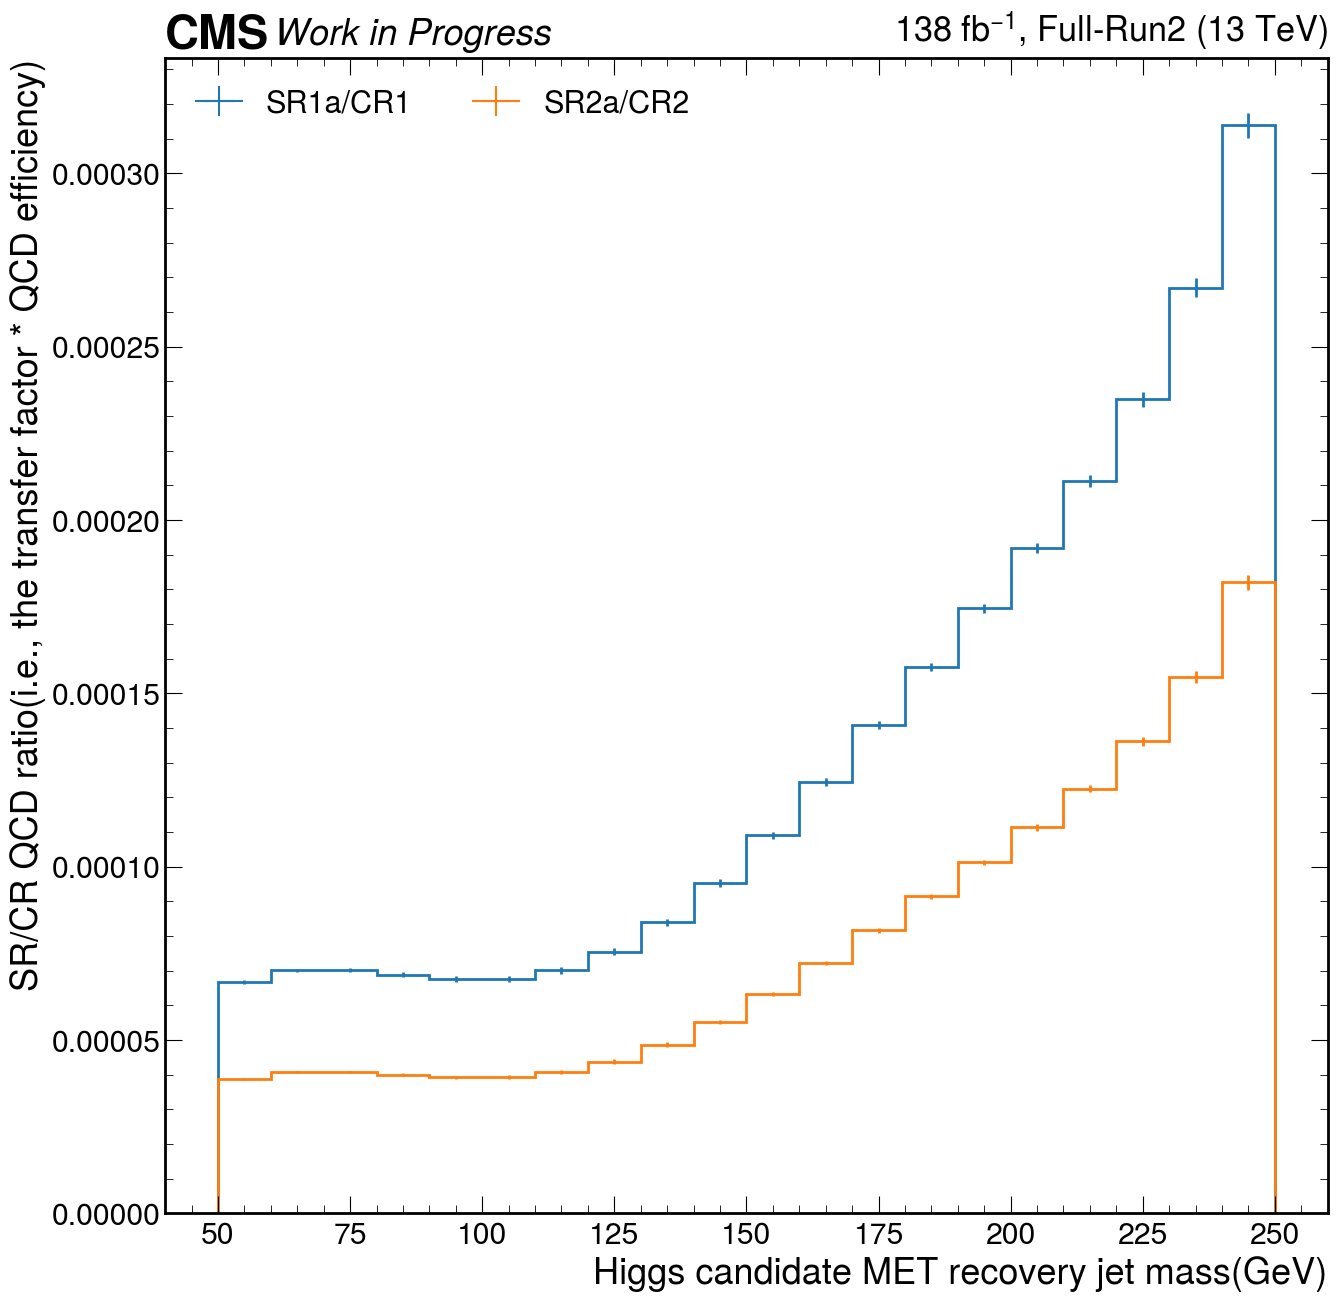

In [35]:
postfit_files = "/home/pku/zhaoyz/Higgs/boostedHWW/combine/f_test/cards/nTF_6/FitShapes.root"
sr_regions = ["SR1a","SR2a"]
cr_regions = ["CR1","CR2"]

histograms = {'h':{},'var':{}}
hep.style.use("CMS")
plt.figure(figsize=(15, 15))
ax = plt.gca()
hep.cms.label(
        "Work in Progress",
        ax=ax,
        data=True,
        lumi=138,
        year="Full-Run2",
    )

for sr_region in sr_regions:
    for cr_region in cr_regions:
        if cr_region[2] != sr_region[2]:continue
        h_sr, var_sr = read_root(filename = postfit_files, dir = sr_region + "_postfit", name = "CMS_HWW_boosted_qcd_datadriven")
        h_cr, var_cr = read_root(filename = postfit_files, dir = cr_region + "_postfit", name = "CMS_HWW_boosted_qcd_datadriven")
        err_sr = np.nan_to_num(error_bar(h_sr, var_sr, type = "mc"))
        err_cr = np.nan_to_num(error_bar(h_cr, var_cr, type = "mc"))
        data1, error1 = h_sr,err_sr
        data2, error2 = h_cr,err_cr
        hist = bh.Histogram(bh.axis.Regular(20, 50, 250), storage=bh.storage.Weight())
        ratio = np.divide(data1, data2, out=np.zeros_like(data1), where=data2!=0)
        ratio_error = ratio * np.sqrt((error1/data1)**2 + (error2/data2)**2)
        hep.histplot(ratio, bins=hist.axes[0].edges, yerr=ratio_error, label=sr_region + "/" + cr_region, histtype='step', stack=False, linewidth=2, ax=ax)    
        ax.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("SR/CR QCD ratio(i.e., the transfer factor * QCD efficiency)")
        # ax.set_yscale('log') 
        ax.legend(loc="upper left", ncol=2, frameon=False, fontsize=22)
plt.savefig(f"{plot_dir}/ratio_1a2a.pdf", bbox_inches='tight')


/tmp/ipykernel_1584653/2771136032.py:34: RuntimeWarning: divide by zero encountered in divide
  number = h**2 / var
/tmp/ipykernel_1584653/2771136032.py:51: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_1584653/2771136032.py:52: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h
/tmp/ipykernel_1584653/2771136032.py:34: RuntimeWarning: divide by zero encountered in divide
  number = h**2 / var
/tmp/ipykernel_1584653/2771136032.py:51: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_1584653/2771136032.py:52: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h


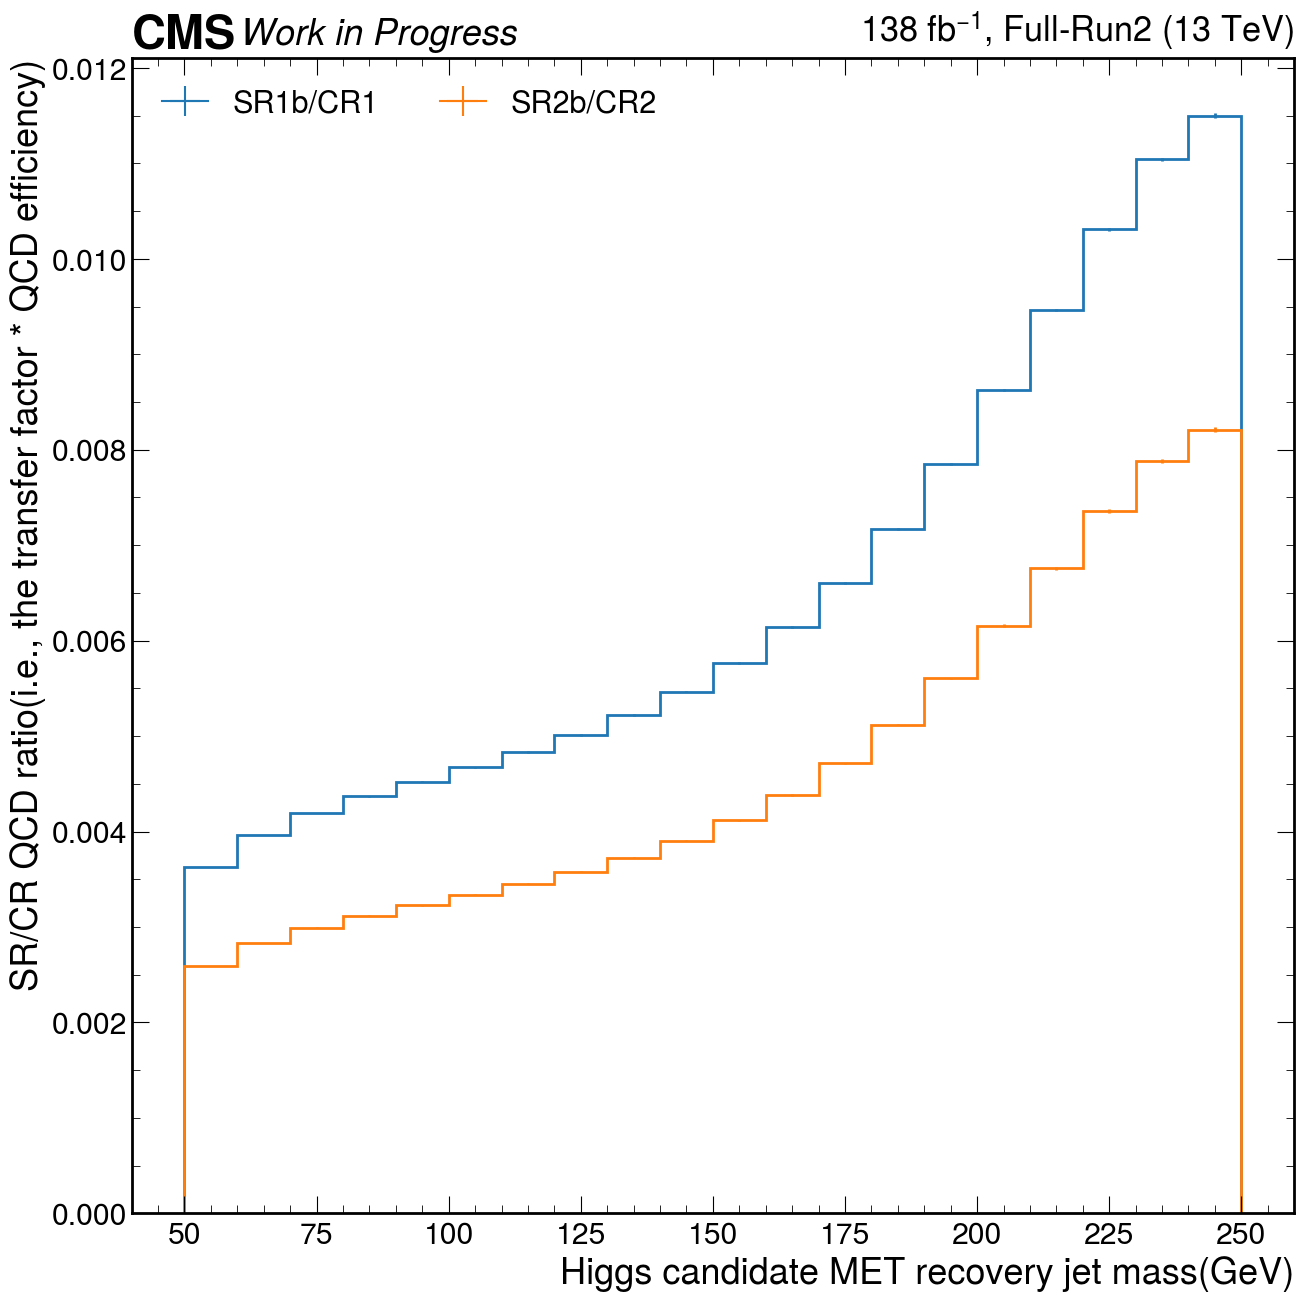

In [36]:
postfit_files = "/home/pku/zhaoyz/Higgs/boostedHWW/combine/f_test/cards/nTF_6/FitShapes.root"
sr_regions = ["SR1b","SR2b"]
cr_regions = ["CR1","CR2"]

histograms = {'h':{},'var':{}}
hep.style.use("CMS")
plt.figure(figsize=(15, 15))
ax = plt.gca()
hep.cms.label(
        "Work in Progress",
        ax=ax,
        data=True,
        lumi=138,
        year="Full-Run2",
    )

for sr_region in sr_regions:
    for cr_region in cr_regions:
        if cr_region[2] != sr_region[2]:continue
        h_sr, var_sr = read_root(filename = postfit_files, dir = sr_region + "_postfit", name = "CMS_HWW_boosted_qcd_datadriven")
        h_cr, var_cr = read_root(filename = postfit_files, dir = cr_region + "_postfit", name = "CMS_HWW_boosted_qcd_datadriven")
        err_sr = np.nan_to_num(error_bar(h_sr, var_sr, type = "mc"))
        err_cr = np.nan_to_num(error_bar(h_cr, var_cr, type = "mc"))
        data1, error1 = h_sr,err_sr
        data2, error2 = h_cr,err_cr
        hist = bh.Histogram(bh.axis.Regular(20, 50, 250), storage=bh.storage.Weight())
        ratio = np.divide(data1, data2, out=np.zeros_like(data1), where=data2!=0)
        ratio_error = ratio * np.sqrt((error1/data1)**2 + (error2/data2)**2)
        hep.histplot(ratio, bins=hist.axes[0].edges, yerr=ratio_error, label=sr_region + "/" + cr_region, histtype='step', stack=False, linewidth=2, ax=ax)    
        ax.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("SR/CR QCD ratio(i.e., the transfer factor * QCD efficiency)")
        # ax.set_yscale('log') 
        ax.legend(loc="upper left", ncol=2, frameon=False, fontsize=22)
plt.savefig(f"{plot_dir}/ratio_1b2b.pdf", bbox_inches='tight')
